В этом проекте предстоит выяснить, от каких самых малоприбыльных рейсов из Анапы можно отказаться в зимнее время.  

### <span style ="color:brown">Описание датасета</span>

<span style ="color:brown">Признак | <span style ="color:brown">Описание</span>
---------|------------
flight_id|Идентификатор рейса
sold_seats|Количество проданных билетов
scheduled_departure|Дата отправления 
scheduled_arrival|Дата прибытия 
total_amount|Полученная сумма за продажу билетов
latitude|Широта
longitude|Долгота
airport_code|Трехбуквенный код аэропорта
model|Название модели самолета
availableseats|Полная заполняемость рейса
departure_airport|Аэропорт назначения

In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7104 sha256=383ce727731be8668917bdc9471f5370da3d29f9cc4d8f4da456965c63d5e016
  Stored in directory: c:\users\8dbe~1\appdata\local\pip\cache\wheels\2f\98\32\afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy import distance
from math import sin, cos, sqrt, radians, asin
import seaborn as sns
plt.style.use('seaborn')
from adjustText import adjust_text
import matplotlib.gridspec as gridspec

In [5]:
df = pd.read_csv('project-4.csv')

In [6]:
df.sample(5)

,flight_id,sold_seats,scheduled_departure,scheduled_arrival,total_amount,latitude,longitude,airport_code,model,availableseats,departure_airport
13,136181,118,2017-01-31 10:05:00.000000,2017-01-31 11:45:00.000000,1689600,55.972599,37.414600,SVO,Boeing 737-300,130,AAQ
58,136486,107,2017-02-02 10:05:00.000000,2017-02-02 11:45:00.000000,1505400,55.972599,37.414600,SVO,Boeing 737-300,130,AAQ
117,136956,96,2017-02-04 09:25:00.000000,2017-02-04 10:15:00.000000,746400,50.643799,36.590099,EGO,Sukhoi Superjet-100,97,AAQ
102,136857,97,2017-02-13 09:25:00.000000,2017-02-13 10:15:00.000000,765300,50.643799,36.590099,EGO,Sukhoi Superjet-100,97,AAQ
56,136479,122,2017-02-21 10:05:00.000000,2017-02-21 11:45:00.000000,1738400,55.972599,37.414600,SVO,Boeing 737-300,130,AAQ


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_id            118 non-null    int64  
 1   sold_seats           118 non-null    int64  
 2   scheduled_departure  118 non-null    object 
 3   scheduled_arrival    118 non-null    object 
 4   total_amount         118 non-null    int64  
 5   latitude             118 non-null    float64
 6   longitude            118 non-null    float64
 7   airport_code         118 non-null    object 
 8   model                118 non-null    object 
 9   availableseats       118 non-null    int64  
 10  departure_airport    118 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 10.3+ KB


In [8]:
# Дополнительные данные:

# удельный расход топлива, кг/ч
fuel_consumption = {'Boeing 737-300': 2600, 'Sukhoi Superjet-100':1700}

# средняя стоимость топлива в зимние месяцы, руб/т
fuel_cost = {1: 41435, 2:39553, 12:47101}

# Расчет цены авивтоплива за полет
def cost(row):
    duration_in_hour = row['flight_time']/60 # получаем часы из длительности в минутах
    cost_in_kg = row['fuel_cost']/1000 # рассчитываем стоимость топлива в кг
    fuel_consump = row['fuel_consumption'] 
    return duration_in_hour*cost_in_kg*fuel_consump

In [9]:
df.sample(5)

,flight_id,sold_seats,scheduled_departure,scheduled_arrival,total_amount,latitude,longitude,airport_code,model,availableseats,departure_airport
68,136642,64,2017-01-30 09:25:00.000000,2017-01-30 10:15:00.000000,531000,50.643799,36.590099,EGO,Sukhoi Superjet-100,97,AAQ
104,136869,97,2017-01-31 09:25:00.000000,2017-01-31 10:15:00.000000,765300,50.643799,36.590099,EGO,Sukhoi Superjet-100,97,AAQ
37,136351,105,2017-02-26 10:05:00.000000,2017-02-26 11:45:00.000000,1555400,55.972599,37.414600,SVO,Boeing 737-300,130,AAQ
115,136951,90,2017-02-02 09:25:00.000000,2017-02-02 10:15:00.000000,720600,50.643799,36.590099,EGO,Sukhoi Superjet-100,97,AAQ
79,136709,87,2017-01-15 09:25:00.000000,2017-01-15 10:15:00.000000,689700,50.643799,36.590099,EGO,Sukhoi Superjet-100,97,AAQ


In [10]:
# Вычисляем расстояние между Анапой и конечным пунктом в км

# approximate radius of earth in km 

R = 6373.0

def dist_calc (row):
    lon1 = 37.347301483154
    lat1 = 45.002101898193
    lat2 = row['latitude']
    lon2 = row['longitude']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))

    distance = R * c

    return distance


df['distance'] = df.apply (lambda row: dist_calc(row), axis=1)

## <p style="text-align: center;"><span style="color:brown"> Коэффициент нагрузки и затраты</p></span>
Почти треть постоянных расходов авиакомпаний связана с полетами. Еще 13% расходов приходится на техническое обслуживание самолетов, 13%-на рекламу, 16% - на услуги у ворот аэропорта, 9% - на обслуживание в полете, а остальное-на прочие расходы.

Значительные затраты на рабочую силу являются обычным явлением и составляют около 75% контролируемых расходов авиакомпании.

#### [<p style="text-align: center;"><span style ="color:brown"> «Как Фактор Загрузки Влияет На Прибыльность Авиакомпании?»](https://www.investopedia.com/ask/answers/041515/how-can-i-use-load-factor-indicator-profitability-airline-industry.asp)

- Коэффициент загрузки-это показатель, используемый в авиационной отрасли, который измеряет процент свободных мест, заполненных пассажирами.
- Высокий коэффициент загрузки указывает на то, что авиакомпания продала большую часть своих свободных мест и отдает предпочтение более низкому коэффициенту загрузки.
- Чем выше коэффициент загрузки, тем больше авиакомпания может распределить свои постоянные расходы между пассажирами.
- Коэффициент загрузки помогает инвесторам и менеджменту определить, насколько хорошо авиакомпания генерирует продажи, покрывает свои расходы и остается прибыльной.
- Авиакомпании имеют низкую маржу прибыли при многих затратах, поэтому наличие высокого коэффициента загрузки имеет важное значение для успеха авиакомпании.
- Доступные мили мест (ASM) - еще один полезный показатель, измеряющий пропускную способность авиакомпании для получения доходов.

In [11]:
# Считаем процент загруженности борта самолета
df['Empty seats proportion'] = round(df.sold_seats*100/df.availableseats, 2)

In [12]:
# Определяем самолеты с меньшей загруженностью чем 75%
df[df['Empty seats proportion'] < 75]

,flight_id,sold_seats,scheduled_departure,scheduled_arrival,total_amount,latitude,longitude,airport_code,model,availableseats,departure_airport,distance,Empty seats proportion
2,136122,97,2017-01-08 10:05:00.000000,2017-01-08 11:45:00.000000,1431000,55.972599,37.414600,SVO,Boeing 737-300,130,AAQ,1220.255704,74.62
38,136360,97,2017-02-05 10:05:00.000000,2017-02-05 11:45:00.000000,1455400,55.972599,37.414600,SVO,Boeing 737-300,130,AAQ,1220.255704,74.62
68,136642,64,2017-01-30 09:25:00.000000,2017-01-30 10:15:00.000000,531000,50.643799,36.590099,EGO,Sukhoi Superjet-100,97,AAQ,630.058282,65.98
93,136807,68,2017-02-23 09:25:00.000000,2017-02-23 10:15:00.000000,531000,50.643799,36.590099,EGO,Sukhoi Superjet-100,97,AAQ,630.058282,70.10


In [13]:
# Конвертируем во время
df['scheduled_departure'] = pd.to_datetime(df['scheduled_departure'])
df['scheduled_arrival'] = pd.to_datetime(df['scheduled_arrival'])

In [14]:
df['scheduled_departure_month'] = df['scheduled_departure'].apply(lambda x: x.month)

In [15]:
# Считаем время проведенное в полете
df['flight_time'] = df['scheduled_arrival'] - df['scheduled_departure']

In [16]:
# Заработанныя сумма за минуту полета
df['flight_time'] = df['flight_time'].apply(lambda x: x/np.timedelta64(1,'m'))
df['total_amount_per_min'] =  df.total_amount/df['flight_time']

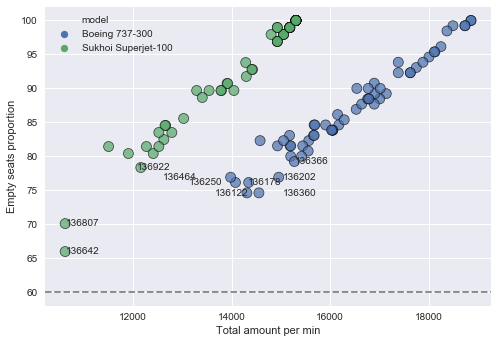

In [25]:
# Визуализируем рейсы с низкой загруженностью

texts = []
y = df['Empty seats proportion']
z = df['total_amount_per_min']
n = df['flight_id']
fig, ax = plt.subplots()
p1 = sns.scatterplot(x=z,
                     y=y,
                     data=df,
                     hue='model',
                     s=100,
                     alpha=0.7,
                     edgecolor='k')
p1.axhline(60, c=(.5, .5, .5), ls='--')
texts = []
for i, txt in enumerate(n):
    if y[i] < 80:
        texts.append(ax.text(z[i], y[i], txt))
adjust_text(texts,
            ax=ax,
            only_move=dict(points='x', text='x', objects='x'),
            autoalign='x')
p1.set(ylabel='Empty seats proportion', xlabel='Total amount per min')
plt.show()

Рейсы с номерами 136807, 136642, 136122 и 136360. Летали с нерентабельной загруженностью, что значит что затраты не окупились. Чем выше загруженность самолета, тем выше выручка. Boing и Sukhoi отличаются друг от друга в плане выручке. У Sukhoi она кажется более низкой, но это в связи с разной продолжительностью полета. Порпобуем рачситать выручку авиарейсов в зависимости от проданых мест в расчете на минуту полета.

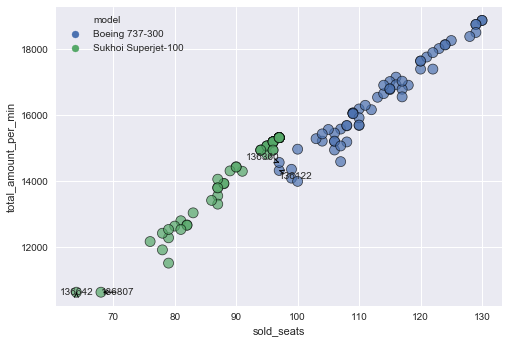

In [26]:
# Визуализируем как соотносится количество проданных билетов с выручкой за минуту в зависимости от количесва
# проданых билетов

texts = []
y = df['total_amount_per_min']
z = df['sold_seats']
n = df['flight_id']
a = df['scheduled_departure_month']
fig, ax = plt.subplots()
p1 = sns.scatterplot(x=z,
                     y=y,
                     data=df,
                     hue='model',
                     s=100,
                     alpha=0.7,
                     edgecolor='k')
# p1.axhline(75, c=(.5, .5, .5), ls='--')
texts = []
for i, txt in enumerate(n):
    if n[i] == 136807 or n[i] == 136642 or n[i] == 136122 or n[i] == 136360:
        texts.append(ax.text(z[i], y[i], txt))
adjust_text(texts,
            ax=ax,
            only_move=dict(points='y', text='y', objects='y'),
            autoalign='x',
            arrowprops=dict(arrowstyle='->', color='black', lw=1))
plt.show()

Согласно полученным данным, при одинаковом колличестве заполненных кресел, рейсы, произведенные Boeing, приносят меньшую выручку. чем на Sukhoi.

Разница между можелями самолетов практически исчезла. 

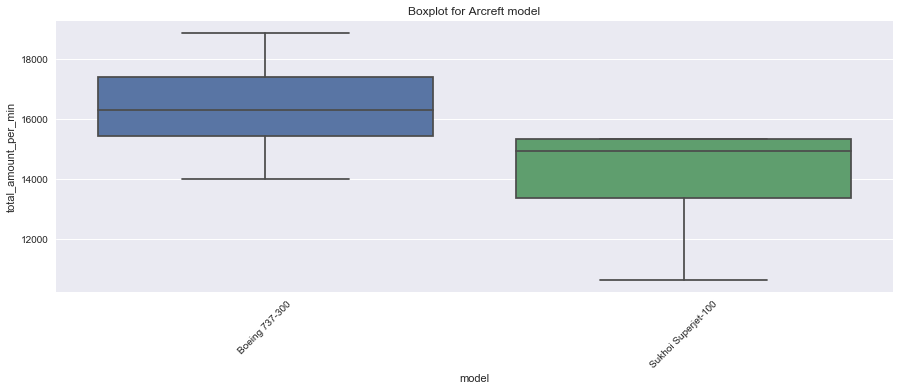

In [27]:
#  Проверим как меняетмя выручка в минуту в зависимоти от модели самолета

fig, ax = plt.subplots(figsize=(15, 5))

sns.boxplot(x='model',
            y='total_amount_per_min',
            data=df.loc[df.loc[:, 'model'].isin(
                df.loc[:, 'model'].value_counts().index[:])],
            ax=ax)

plt.xticks(rotation=45)
ax.set_title('Boxplot for Arcreft model')

plt.show()

Boeing зарабатывает немного больше Sukhoi

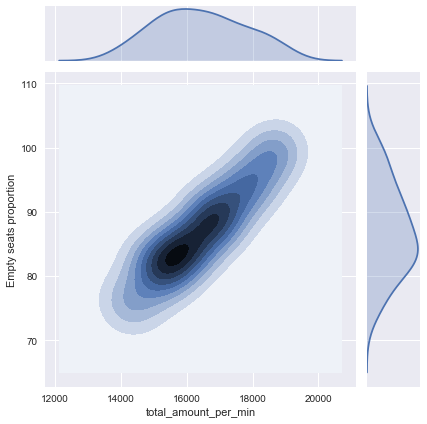

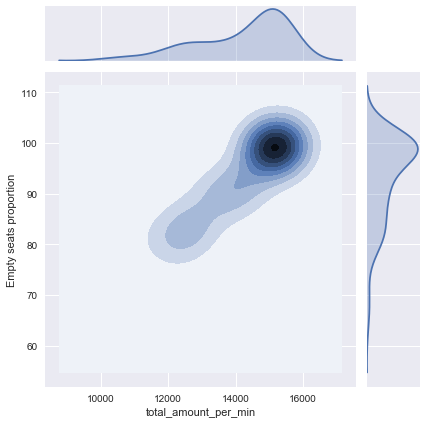

In [28]:
# Кресла самолетов Sukhoi заполняются чаще, чем у Boeing

p = sns.jointplot(data=df[(df.model == 'Boeing 737-300')],
              x='total_amount_per_min',
              y='Empty seats proportion',
              kind='kde')
p2 = sns.jointplot(data=df[(df.model == 'Sukhoi Superjet-100')],
              x='total_amount_per_min',
              y='Empty seats proportion',
              kind='kde')

In [29]:
df['fuel_consumption'] = df['model'].map(fuel_consumption)
df['fuel_cost'] = df['scheduled_departure_month'].map(fuel_cost)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   flight_id                  118 non-null    int64         
 1   sold_seats                 118 non-null    int64         
 2   scheduled_departure        118 non-null    datetime64[ns]
 3   scheduled_arrival          118 non-null    datetime64[ns]
 4   total_amount               118 non-null    int64         
 5   latitude                   118 non-null    float64       
 6   longitude                  118 non-null    float64       
 7   airport_code               118 non-null    object        
 8   model                      118 non-null    object        
 9   availableseats             118 non-null    int64         
 10  departure_airport          118 non-null    object        
 11  distance                   118 non-null    float64       
 12  Empty se

In [31]:
# добавляем столбец с затратами на рейс
df['flight_cost'] = round(df.apply(lambda x: cost(x), axis=1), 2)

# считаем прибыльность рейсов
df['profit'] = round(df['total_amount'] - df['flight_cost'], 2)

In [32]:
df['profit_in_min'] = df.profit/df['flight_time']

In [33]:
df.sample(5)

,flight_id,sold_seats,scheduled_departure,scheduled_arrival,total_amount,latitude,longitude,airport_code,model,availableseats,...,distance,Empty seats proportion,scheduled_departure_month,flight_time,total_amount_per_min,fuel_consumption,fuel_cost,flight_cost,profit,profit_in_min
77,136678,80,2017-01-28 09:25:00,2017-01-28 10:15:00,631200,50.643799,36.590099,EGO,Sukhoi Superjet-100,97,...,630.058282,82.47,1,50.0,12624.0,1700,41435,58699.58,572500.42,11450.0084
40,136383,106,2017-01-25 10:05:00,2017-01-25 11:45:00,1493200,55.972599,37.414600,SVO,Boeing 737-300,130,...,1220.255704,81.54,1,100.0,14932.0,2600,41435,179551.67,1313648.33,13136.4833
47,136428,115,2017-01-21 10:05:00,2017-01-21 11:45:00,1678600,55.972599,37.414600,SVO,Boeing 737-300,130,...,1220.255704,88.46,1,100.0,16786.0,2600,41435,179551.67,1499048.33,14990.4833
43,136403,129,2017-02-20 10:05:00,2017-02-20 11:45:00,1873800,55.972599,37.414600,SVO,Boeing 737-300,130,...,1220.255704,99.23,2,100.0,18738.0,2600,39553,171396.33,1702403.67,17024.0367
20,136249,123,2017-02-14 10:05:00,2017-02-14 11:45:00,1800600,55.972599,37.414600,SVO,Boeing 737-300,130,...,1220.255704,94.62,2,100.0,18006.0,2600,39553,171396.33,1629203.67,16292.0367


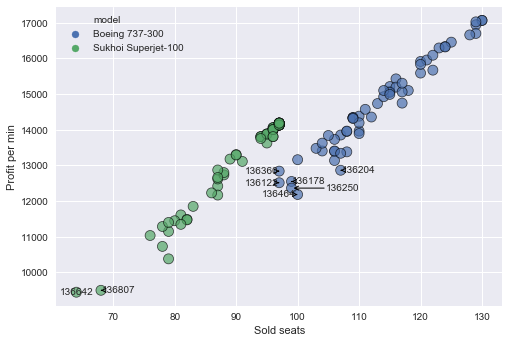

In [34]:
# Визуализируем как соотносится количество проданных билетов с выручкой за минуту в зависимости от количесва
# проданых билетов и тратой на авиатопливо

texts = []
y = df['profit_in_min']
z = df['sold_seats']
n = df['flight_id']
a = df['scheduled_departure_month']
b = df.total_amount
c = df['Empty seats proportion']
fig, ax = plt.subplots()
p1 = sns.scatterplot(x=z,
                     y=y,
                     data=df,
                     hue='model',
                     s=100,
                     alpha=0.7,
                     edgecolor='k')
texts = []
for i, txt in enumerate(n):
    if b[i] < 1460000 and df['model'][i] == 'Boeing 737-300' or c[
            i] < 75:
        texts.append(ax.text(z[i], y[i], txt))
adjust_text(texts,
            ax=ax,
            only_move=dict(points='x', text='x', objects='x'),
            autoalign='x',
            arrowprops=dict(arrowstyle='->', color='black', lw=1))
p1.set(ylabel='Profit per min', xlabel='Sold seats')
plt.show()

In [35]:
# Список рекомендуемых рейсов на отмену
df[(df.total_amount < 1460000) & (df.model == "Boeing 737-300") | (df['Empty seats proportion'] < 75)]

,flight_id,sold_seats,scheduled_departure,scheduled_arrival,total_amount,latitude,longitude,airport_code,model,availableseats,...,distance,Empty seats proportion,scheduled_departure_month,flight_time,total_amount_per_min,fuel_consumption,fuel_cost,flight_cost,profit,profit_in_min
2,136122,97,2017-01-08 10:05:00,2017-01-08 11:45:00,1431000,55.972599,37.414600,SVO,Boeing 737-300,130,...,1220.255704,74.62,1,100.0,14310.0,2600,41435,179551.67,1251448.33,12514.4833
12,136178,99,2017-01-29 10:05:00,2017-01-29 11:45:00,1434600,55.972599,37.414600,SVO,Boeing 737-300,130,...,1220.255704,76.15,1,100.0,14346.0,2600,41435,179551.67,1255048.33,12550.4833
16,136204,107,2017-02-23 10:05:00,2017-02-23 11:45:00,1457800,55.972599,37.414600,SVO,Boeing 737-300,130,...,1220.255704,82.31,2,100.0,14578.0,2600,39553,171396.33,1286403.67,12864.0367
21,136250,99,2017-02-08 10:05:00,2017-02-08 11:45:00,1407800,55.972599,37.414600,SVO,Boeing 737-300,130,...,1220.255704,76.15,2,100.0,14078.0,2600,39553,171396.33,1236403.67,12364.0367
38,136360,97,2017-02-05 10:05:00,2017-02-05 11:45:00,1455400,55.972599,37.414600,SVO,Boeing 737-300,130,...,1220.255704,74.62,2,100.0,14554.0,2600,39553,171396.33,1284003.67,12840.0367
54,136464,100,2017-01-09 10:05:00,2017-01-09 11:45:00,1398000,55.972599,37.414600,SVO,Boeing 737-300,130,...,1220.255704,76.92,1,100.0,13980.0,2600,41435,179551.67,1218448.33,12184.4833
68,136642,64,2017-01-30 09:25:00,2017-01-30 10:15:00,531000,50.643799,36.590099,EGO,Sukhoi Superjet-100,97,...,630.058282,65.98,1,50.0,10620.0,1700,41435,58699.58,472300.42,9446.0084
93,136807,68,2017-02-23 09:25:00,2017-02-23 10:15:00,531000,50.643799,36.590099,EGO,Sukhoi Superjet-100,97,...,630.058282,70.10,2,50.0,10620.0,1700,39553,56033.42,474966.58,9499.3316


In [38]:
# общая сумма дохода только с учетом затрат на топливо
df.profit.sum()

125073878.25

In [39]:
df[(df.total_amount < 1460000) & (df.model == "Boeing 737-300") |
   (df['Empty seats proportion'] < 75)].flight_id.to_list()

[136122, 136178, 136204, 136250, 136360, 136464, 136642, 136807]